In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [2]:
clean_df = pd.read_csv('clean_data.csv')
clean_df = clean_df.drop(columns = ['Unnamed: 0'])

In [3]:
len(clean_df)

1447

In [4]:
clean_df.sample(3)

,Images_links,Article_links,Num_views,Repair_types,Article_code,im_dir,Repair_types_id
475,https://cdn-p.cian.site/images/85/235/341/kvar...,https://www.cian.ru/sale/flat/280873944/,484,Евроремонт,"<html lang=""ru""><head><script charset=""windows...",im_data_new/image_0475.jpg,2
937,https://cdn-p.cian.site/images/57/205/741/kvar...,https://www.cian.ru/sale/flat/282555805/,802,Дизайнерский,"<html lang=""ru""><head><script charset=""utf-8"" ...",im_data_new/image_0937.jpg,1
1155,https://cdn-p.cian.site/images/25/779/441/1449...,https://www.cian.ru/sale/flat/280702464/,967,Евроремонт,"<html lang=""ru""><head><script async="""" src=""ht...",im_data_new/image_1155.jpg,2


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(clean_df['im_dir'], clean_df['Repair_types_id'], test_size=0.33, random_state=42, stratify = clean_df['Repair_types'])


In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None, transform=None):
        self.const_dir = 'im_data/image_'
        self.transform = transform
        self.num_elem = len(X)
        self.X = X
        self.target = y

    def __getitem__(self, idx):
#         im_name = self.const_dir + str(idx).zfill(4) + '.jpg'
        image = torchvision.io.read_image(self.X.iloc[idx]) / 255

        if (self.transform is not None):
            image = self.transform(image)
        if (self.target is not None):
            # return image, torch.Tensor(self.X.iloc[idx][['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']])
            return image, self.target.iloc[idx]
        return image
    
    def __len__(self):
        return self.num_elem

In [7]:
import torchvision.transforms as T

train_transform = nn.Sequential(
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
)

test_transform = nn.Sequential(
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
)

In [8]:
train_dataset = MyDataset(X_train, y_train, transform=train_transform)
test_dataset = MyDataset(X_test, y_test, transform=test_transform)

batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
for i in range(len(train_dataset)):
    try:
        train_dataset[i]
    except:
        print(X_train.iloc[i])

In [10]:
for i in range(len(test_dataset)):
    try:
        test_dataset[i]
    except:
        print(X_test.iloc[i])

im_data_new/image_1330.jpg


In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
# def focal_loss_fixed(y_pred, y_true):
#     gamma=2.
#     alpha=4.
#     """Focal loss for multi-classification
#     FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
#     Notice: y_pred is probability after softmax
#     gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
#     d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
#     Focal Loss for Dense Object Detection
#     https://arxiv.org/abs/1708.02002

#     Arguments:
#         y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
#         y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

#     Keyword Arguments:
#         gamma {float} -- (default: {2.0})
#         alpha {float} -- (default: {4.0})

#     Returns:
#         [tensor] -- loss.
#     """
#     epsilon = 1.e-9
# #     y_true = tf.convert_to_tensor(y_true, tf.float32)
# #     y_pred = tf.convert_to_tensor(y_pred, tf.float32)

#     model_out = tf.add(y_pred, epsilon)
#     ce = tf.multiply(y_true, -tf.log(model_out))
#     weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
#     fl = tf.multiply(alpha, tf.multiply(weight, ce))
#     reduced_fl = tf.reduce_max(fl, axis=1)
#     return tf.reduce_mean(reduced_fl)

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
    
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [14]:
# def focal_loss(inputs, targets):
#     alpha=1
#     gamma=2
#     logits=False
#     reduce=True
#     BCE_loss = nn.CrossEntropyLoss()(inputs, targets, reduce=False)

#     pt = torch.exp(-BCE_loss)
#     F_loss = alpha * (1-pt)**gamma * BCE_loss

#     if reduce:
#         return torch.mean(F_loss)
#     else:
#         return F_loss

In [15]:
from tqdm.notebook import tqdm
# from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from IPython.display import clear_output

def train_epoch(model, optimizer):
    loss_log, roc_auc_log = [], []
    model.train()
    # progress_bar = tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}')
    i = 0
    for x_batch, y_batch in tqdm(train_loader):
#         if i > 10:
#             break
#         print(i)
        data = x_batch.to(device)
        target = y_batch.to(device)

        optimizer.zero_grad()
        output = model(data)
#         print(output, y_batch)
#         break
        roc_auc = 0
        with torch.no_grad():
            try:
                roc_auc = roc_auc_score(y_batch.cpu().detach().numpy(), nn.functional.softmax(output).cpu().detach().numpy(), multi_class='ovr')
            except:
                pass
            roc_auc_log.append(roc_auc)

        loss = FocalLoss()(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
        i += 1
    return loss_log, roc_auc_log

def test(model):
    model.to(device)
    loss_log, roc_auc_log = [], []
    model.eval()
    i = 0
    for x_batch, y_batch in tqdm(test_loader):
#         if i > 10:
#             break
#         print(i)
        data = x_batch.to(device)
        target = y_batch.to(device)

        output = model(data)
        loss = FocalLoss()(output, target)
        roc_auc = 0
        with torch.no_grad():
            try:
                roc_auc = roc_auc_score(y_batch.cpu().detach().numpy(), nn.functional.softmax(output).cpu().detach().numpy(), multi_class='ovr')
            except:
                pass
            roc_auc_log.append(roc_auc)
        
        loss = loss.item()
        loss_log.append(loss)
        i += 1
    return loss_log, roc_auc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    hist = []
    model.to(device)
    train_log, train_roc_auc_log = [], []
    val_log, val_roc_auc_log = [], []

    batchsize = 32

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_roc_auc = train_epoch(model, opt)

        val_loss, val_roc_auc = test(model)

        train_log.extend(train_loss)
        train_roc_auc_log.extend(train_roc_auc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_roc_auc_log.append((steps * (epoch + 1), np.mean(val_roc_auc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_roc_auc_log, val_roc_auc_log, title='roc_auc')
        print("Epoch {} roc_auc = {:.2%}".format(epoch, val_roc_auc_log[-1][1]))
        hist += [(epoch, val_roc_auc_log[-1][1])]
#         torch.save(model, './model_regnet_AdamW1' + str(epoch) + '.pth')
    
    for epoch, auc in hist:
        print(epoch, ': ', auc)
            
    print("Final roc_auc: {:.2%}".format(val_roc_auc_log[-1][1]))

In [16]:
# !pip install --upgrade pip

In [17]:
# !pip install efficientnet_pytorch

In [20]:
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = models.regnet_y_1_6gf(num_classes=4)
# model.stem[0] = torch.nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


# model = models.resnet18(num_classes=4, pretrained=False)
# model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=4)
# model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model = model.to(device)
print("Total number of trainable parameters:", count_parameters(model))

Loaded pretrained weights for efficientnet-b1
Total number of trainable parameters: 6518308


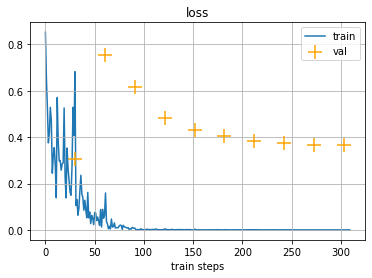

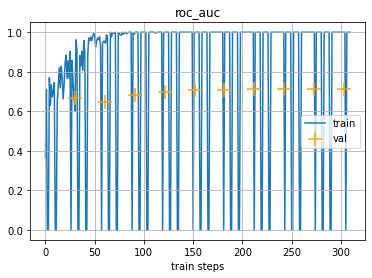

Epoch 9 roc_auc = 71.24%
0 :  0.6677966229139541
1 :  0.6492660062000191
2 :  0.6824345467811513
3 :  0.6988711220584254
4 :  0.7074963225338471
5 :  0.7102363270831956
6 :  0.7104209491850376
7 :  0.7112480508755609
8 :  0.7134510397034803
9 :  0.7123770572726009
Final roc_auc: 71.24%


In [21]:
opt = torch.optim.AdamW(model.parameters(), lr=0.001)
train(model, opt, 10)

In [22]:
torch.save(model, './eff_net_model')

In [33]:
test_dataset[0][0].shape

torch.Size([3, 224, 224])

In [36]:
img = torch.reshape(test_dataset[0][0], (1, 3, 224, 224))

In [38]:
model.extract_features(img)

torch.Size([1, 1280, 7, 7])

In [20]:
test_loader1 = DataLoader(test_dataset)

In [39]:
predictions = np.array([])
true_labels = np.array([])
for x_batch, y_batch in tqdm(test_loader):
    data = x_batch.to(device)
    target = y_batch.to(device)
    output = model(data)
    preds = np.argmax(nn.functional.softmax(output).cpu().detach().numpy(), 1)
    predictions = np.append(predictions, preds)
    true_labels = np.append(true_labels, target)

  0%|          | 0/15 [00:00<?, ?it/s]

<ipython-input-39-75c1f07bcc97>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = np.argmax(nn.functional.softmax(output).cpu().detach().numpy(), 1)


In [41]:
df = pd.DataFrame(
    {
        'preds': predictions,
        'target': true_labels
    }
)

In [49]:
df['is_true'] = df['target'] == df['preds']

In [50]:
df

,preds,target,is_true
0,0.0,0.0,True
1,1.0,1.0,True
2,0.0,0.0,True
3,0.0,0.0,True
4,1.0,1.0,True
...,...,...,...
473,0.0,0.0,True
474,1.0,3.0,False
475,0.0,0.0,True
476,1.0,1.0,True


In [54]:
df.groupby(by='target').mean()[['is_true']]

,is_true
target,
0.0,0.885246
1.0,0.841202
2.0,0.582418
3.0,0.031250


In [55]:
df[df['target'] == 3]

,preds,target,is_true
13,1.0,3.0,False
15,0.0,3.0,False
40,1.0,3.0,False
53,2.0,3.0,False
56,1.0,3.0,False
57,3.0,3.0,True
82,0.0,3.0,False
101,1.0,3.0,False
102,1.0,3.0,False
114,1.0,3.0,False
